### loss graphs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
chpt_lstm = '../data/lightning_logs/version_55/metrics.csv'
chpt_txl  = '../data/lightning_logs/version_51/metrics.csv'

In [32]:
csv = pd.read_csv(chpt_lstm)
csv['created_at'] =  pd.to_datetime(csv['created_at'], format='%Y%m%d %H:%M:%S.%f')
csv['created_at'] =  (csv['created_at'] - csv['created_at'][csv.first_valid_index()]).dt.total_seconds()
csv = csv.set_index('created_at')
csv

,train_loss,epoch,val_loss,valid_roc_auc,valid_acc
created_at,,,,,
0.000000,0.098585,0,NaN,NaN,NaN
0.620962,0.078722,0,NaN,NaN,NaN
1.192734,0.077337,0,NaN,NaN,NaN
1.758596,0.093673,0,NaN,NaN,NaN
2.333053,0.084425,0,NaN,NaN,NaN
...,...,...,...,...,...
90263.430217,0.076333,5,NaN,NaN,NaN
90264.674053,0.066951,5,NaN,NaN,NaN
90265.928700,0.055678,5,NaN,NaN,NaN


In [56]:
def plot_losses(csv_path, ax,avg_win_sz=500,time=False):
    csv = pd.read_csv(csv_path)
    if time:
        csv['created_at'] =  pd.to_datetime(csv['created_at'], format='%Y%m%d %H:%M:%S.%f')
        csv['Seconds'] =  (csv['created_at'] - csv['created_at'][csv.first_valid_index()]).dt.total_seconds()
        csv = csv.set_index('Seconds')

    trn = csv[csv['train_loss'].notnull()]
    trn['train_loss'].rolling(avg_win_sz).mean().plot(ax=ax)
  
    val = csv[csv['val_loss'].notnull()]
    val['val_loss'].plot(ax=ax)

In [57]:
def plot_roc_auc(csv_path,ax,time=False):
    csv = pd.read_csv(csv_path)
    if time:
        csv['created_at'] =  pd.to_datetime(csv['created_at'], format='%Y%m%d %H:%M:%S.%f')
        csv['Seconds'] =  (csv['created_at'] - csv['created_at'][csv.first_valid_index()]).dt.total_seconds()
        csv = csv.set_index('Seconds')
        
    val = csv[csv['val_loss'].notnull()]
    val['valid_roc_auc'].plot(ax=ax)

Text(0.5, 1.0, 'ROC AUC vs time')

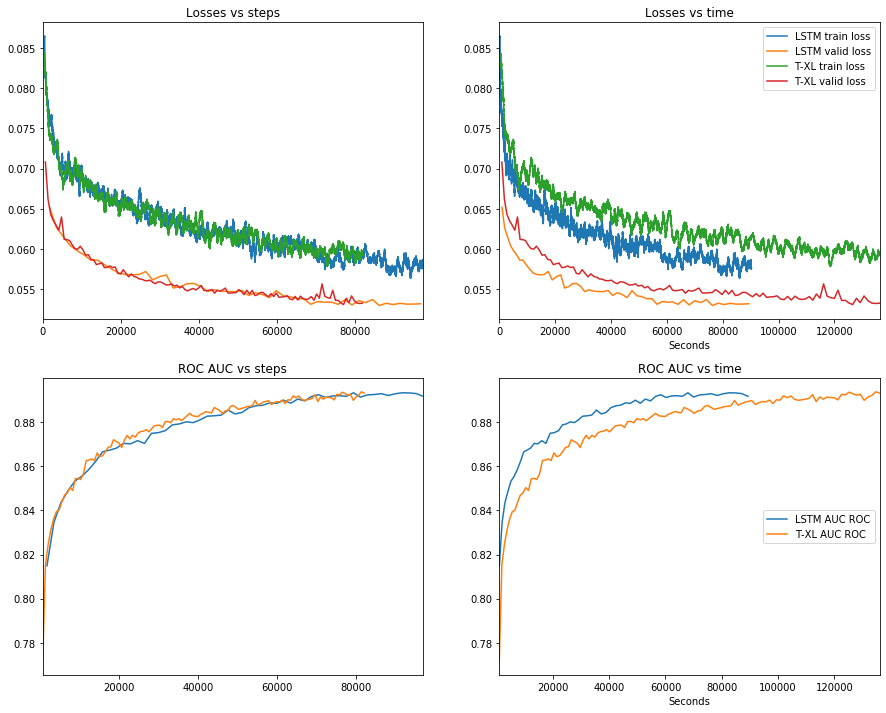

In [60]:
fig, axs = plt.subplots(2,2,figsize=(15,12))

plot_losses(chpt_lstm,axs[0,0])
plot_losses(chpt_txl, axs[0,0])
axs[0,0].set_title('Losses vs steps')

plot_losses(chpt_lstm,axs[0,1],time=True)
plot_losses(chpt_txl, axs[0,1],time=True)
axs[0,1].legend(['LSTM train loss','LSTM valid loss','T-XL train loss','T-XL valid loss'])
axs[0,1].set_title('Losses vs time')

plot_roc_auc(chpt_lstm,axs[1,0])
plot_roc_auc(chpt_txl, axs[1,0])
axs[1,0].set_title('ROC AUC vs steps')

plot_roc_auc(chpt_lstm,axs[1,1],time=True)
plot_roc_auc(chpt_txl, axs[1,1] ,time=True)
plt.legend(['LSTM AUC ROC','T-XL AUC ROC'],loc="center right")
axs[1,1].set_title('ROC AUC vs time')

## Grad CAM

In [1]:
import sys,os,h5py
import matplotlib.pyplot as plt
import numpy as np 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

sys.path.append(os.path.dirname(os.getcwd())) #add parent folder to PATH
import lib.models as models
import transformers as ts

In [7]:
test = np.load('../data/Processed/test.npz')
# X_test = torch.tensor(test['arr_0'][:])
x_sample = torch.tensor(test['arr_0'][:1]).long()
x_sample.shape

torch.Size([1, 1000])

In [21]:
class Experiment(pl.LightningModule):
    def __init__(self,model):
        super(Experiment, self).__init__()
        self.model = model

In [23]:
cfg = ts.TransfoXLConfig(d_model=352)

model = models.ResTransXL(vocab_size=4, d_emb=64, tsfm_cfg=cfg,skip_cnt=True,fc_h_dim=925,
                          n_res_blocks=3, res_k=16,lin_p=0.1,LSTM=True)
use_amp = True
chpt_path = '../data/lightning_logs/version_66/checkpoints/_ckpt_epoch_5.ckpt'
exp = Experiment(model)
exp.load_state_dict(torch.load(chpt_path)['state_dict'])
model.summary()

Model parameters:				
Resnet part:		8894k
Transformer-XL part:	1988k
Linear part:		122952k
Total:			133835k


In [4]:
# for i in model.named_modules():
#     print(i[0])
# model.res.layers[3]

In [24]:
global saved_acts
global saves_grads

def save_activations(module, input, output):
    global saved_acts
    saved_acts = output

def save_gradients(module, grad_input, grad_output):
    global saves_grads
    saves_grads = grad_output

    
fwd_handle = model.res.layers[3].register_forward_hook(save_activations)
bwd_handle = model.res.layers[3].register_backward_hook(save_gradients)

In [25]:
model.eval()
y_hat = model(x_sample)
y_pred = torch.sigmoid(y_hat[0])

In [30]:
_, i = y_pred.topk(1)
i

tensor([[810]])

In [31]:
y_hat[0][:,i].backward()

In [32]:
saved_acts[0].shape, saves_grads[0].shape

(torch.Size([352, 125]), torch.Size([1, 352, 125]))

In [33]:
alpha_c = saves_grads[0][0].mean(1)
alpha_c.shape

torch.Size([352])

In [34]:
grad_cam = F.relu((alpha_c[:,None]*saved_acts[0]).sum(0,keepdim=True)).detach().numpy()
grad_cam.shape

(1, 125)

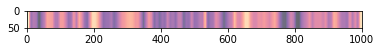

In [37]:
_, ax = plt.subplots()
# funcion convertir secuencia en bases
ax.imshow(grad_cam,alpha=0.6, extent=(0,1000,50,0),interpolation='bilinear',cmap='magma')

In [ ]:
fwd_handle.remove()
bwd_handle.remove()

In [ ]:
# srcs
# https://arxiv.org/pdf/1610.02391.pdf
# https://github.com/HaebinShin/grad-cam-text
# https://github.com/utkuozbulak/pytorch-cnn-visualizations
# https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
# https://course.fast.ai/videos/?lesson=6
#TODO improve it with guided backpropagation